[14:37:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


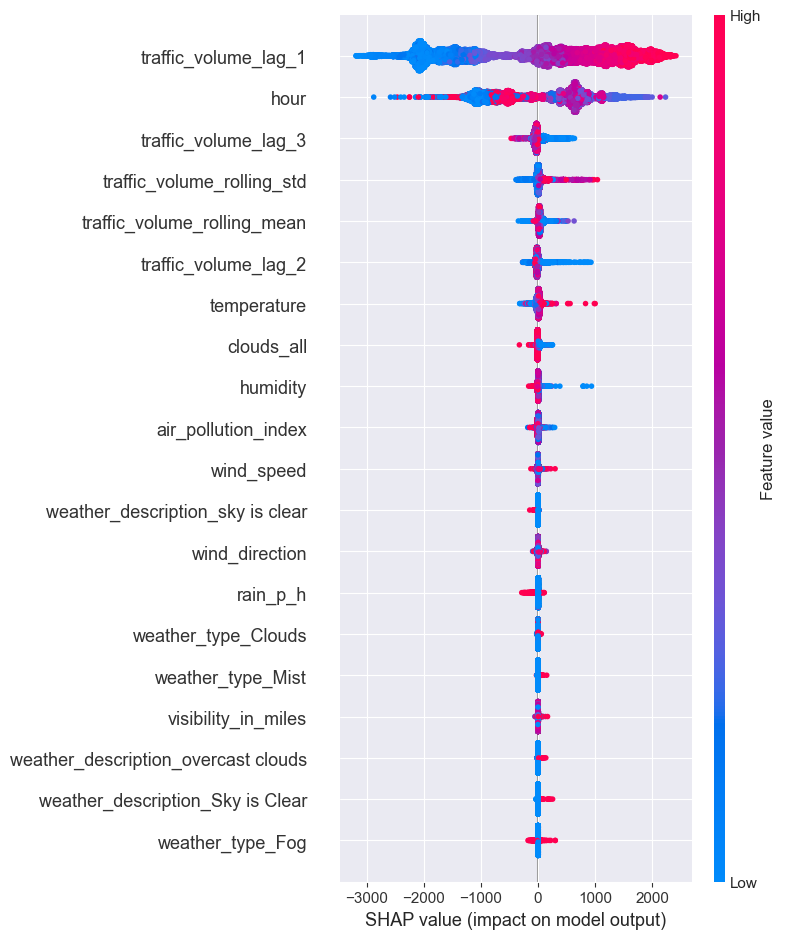

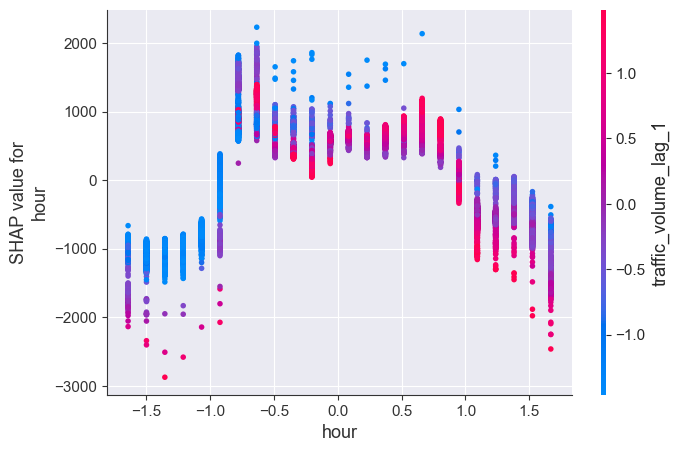

TypeError: The feature_names arg requires a list or numpy array.

In [11]:
import pandas as pd
import xgboost as xgb
import joblib
import shap

# Load your model
model = xgb.XGBRegressor()
model.load_model('best_xgboost_model_V1.json')

# Load your scaler
scaler = joblib.load('scalerV1.save')

# Load and preprocess your training dataset
train_df = pd.read_csv('Train.csv')
train_df['date_time'] = pd.to_datetime(train_df['date_time'])
train_df.sort_values('date_time', inplace=True)
train_df.set_index('date_time', inplace=True)

# Check if 'hour' column needs to be created
if 'hour' not in train_df.columns:
    train_df['hour'] = train_df.index.hour

# One-hot encode categorical features
train_df_processed = pd.get_dummies(train_df, columns=['is_holiday', 'weather_type', 'weather_description'], drop_first=True)

# Create lag features and rolling window statistics for the target variable
target = 'traffic_volume'
for i in range(1, 4):
    train_df_processed[f'traffic_volume_lag_{i}'] = train_df_processed[target].shift(i)
train_df_processed['traffic_volume_rolling_mean'] = train_df_processed[target].rolling(window=3).mean().shift(1)
train_df_processed['traffic_volume_rolling_std'] = train_df_processed[target].rolling(window=3).std().shift(1)

# Drop rows with NaN values resulting from lagged features
train_df_processed.dropna(inplace=True)

# Split the dataset into features (X) and target (y)
X_train = train_df_processed.drop(target, axis=1)
y_train = train_df_processed[target]

# Scale the features
X_train_scaled = scaler.transform(X_train)

# Compute SHAP values for your model
explainer = shap.Explainer(model)
shap_values = explainer(X_train_scaled)

# Summary plot
shap.summary_plot(shap_values.values, X_train_scaled, feature_names=X_train.columns)

# Dependence plot for a single feature
# Replace 'temperature' with the actual feature name you wish to examine
shap.dependence_plot('hour', shap_values.values, X_train_scaled, feature_names=X_train.columns)

# Force plot for a single prediction
instance_index = 0  # Can be any index from your dataset
shap.force_plot(explainer.expected_value, shap_values.values[instance_index], feature_names=X_train.columns)

# Decision plot for a single prediction
shap.decision_plot(explainer.expected_value, shap_values.values[instance_index], feature_names=X_train.columns)
